# Importing Libraries and Data

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
from keras.utils import np_utils
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
import keras as keras
from tensorflow.keras import layers

In [ ]:
from keras.datasets import cifar10
(X_train, y_train), (X_valid, y_valid) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)

In [ ]:
print('total classes: ',y_valid.shape[1])
num_classes = y_valid.shape[1]

total classes:  10


# MODEL 1

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32,3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
epochs = 25
lrate = 0.01
decay = lrate/epochs
nadam=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [ ]:
model1=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=32)

Epoch 1/25
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4311 - accuracy: 0.4858 - val_loss: 1.1050 - val_accuracy: 0.6182
Epoch 2/25
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0964 - accuracy: 0.6122 - val_loss: 0.9801 - val_accuracy: 0.6605
Epoch 3/25
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9897 - accuracy: 0.6482 - val_loss: 0.9640 - val_accuracy: 0.6688
Epoch 4/25
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9198 - accuracy: 0.6751 - val_loss: 0.9232 - val_accuracy: 0.6849
Epoch 5/25
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8733 - accuracy: 0.6918 - val_loss: 0.8862 - val_accuracy: 0.6948
Epoch 6/25
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8358 - accuracy: 0.7056 - val_loss: 0.8500 - val_accuracy: 0.7023
Epoch 7/25
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8100 - accuracy: 0.7172 - val_loss: 0.8676 - val_ac

# Augmentation Layer

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.4),
])

# CUSTOM MODEL 3 INCEPTION MODULES

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   96          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 4)    16          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 3)    0           input_1[0][0]                    
_______________________________________________________________________________________

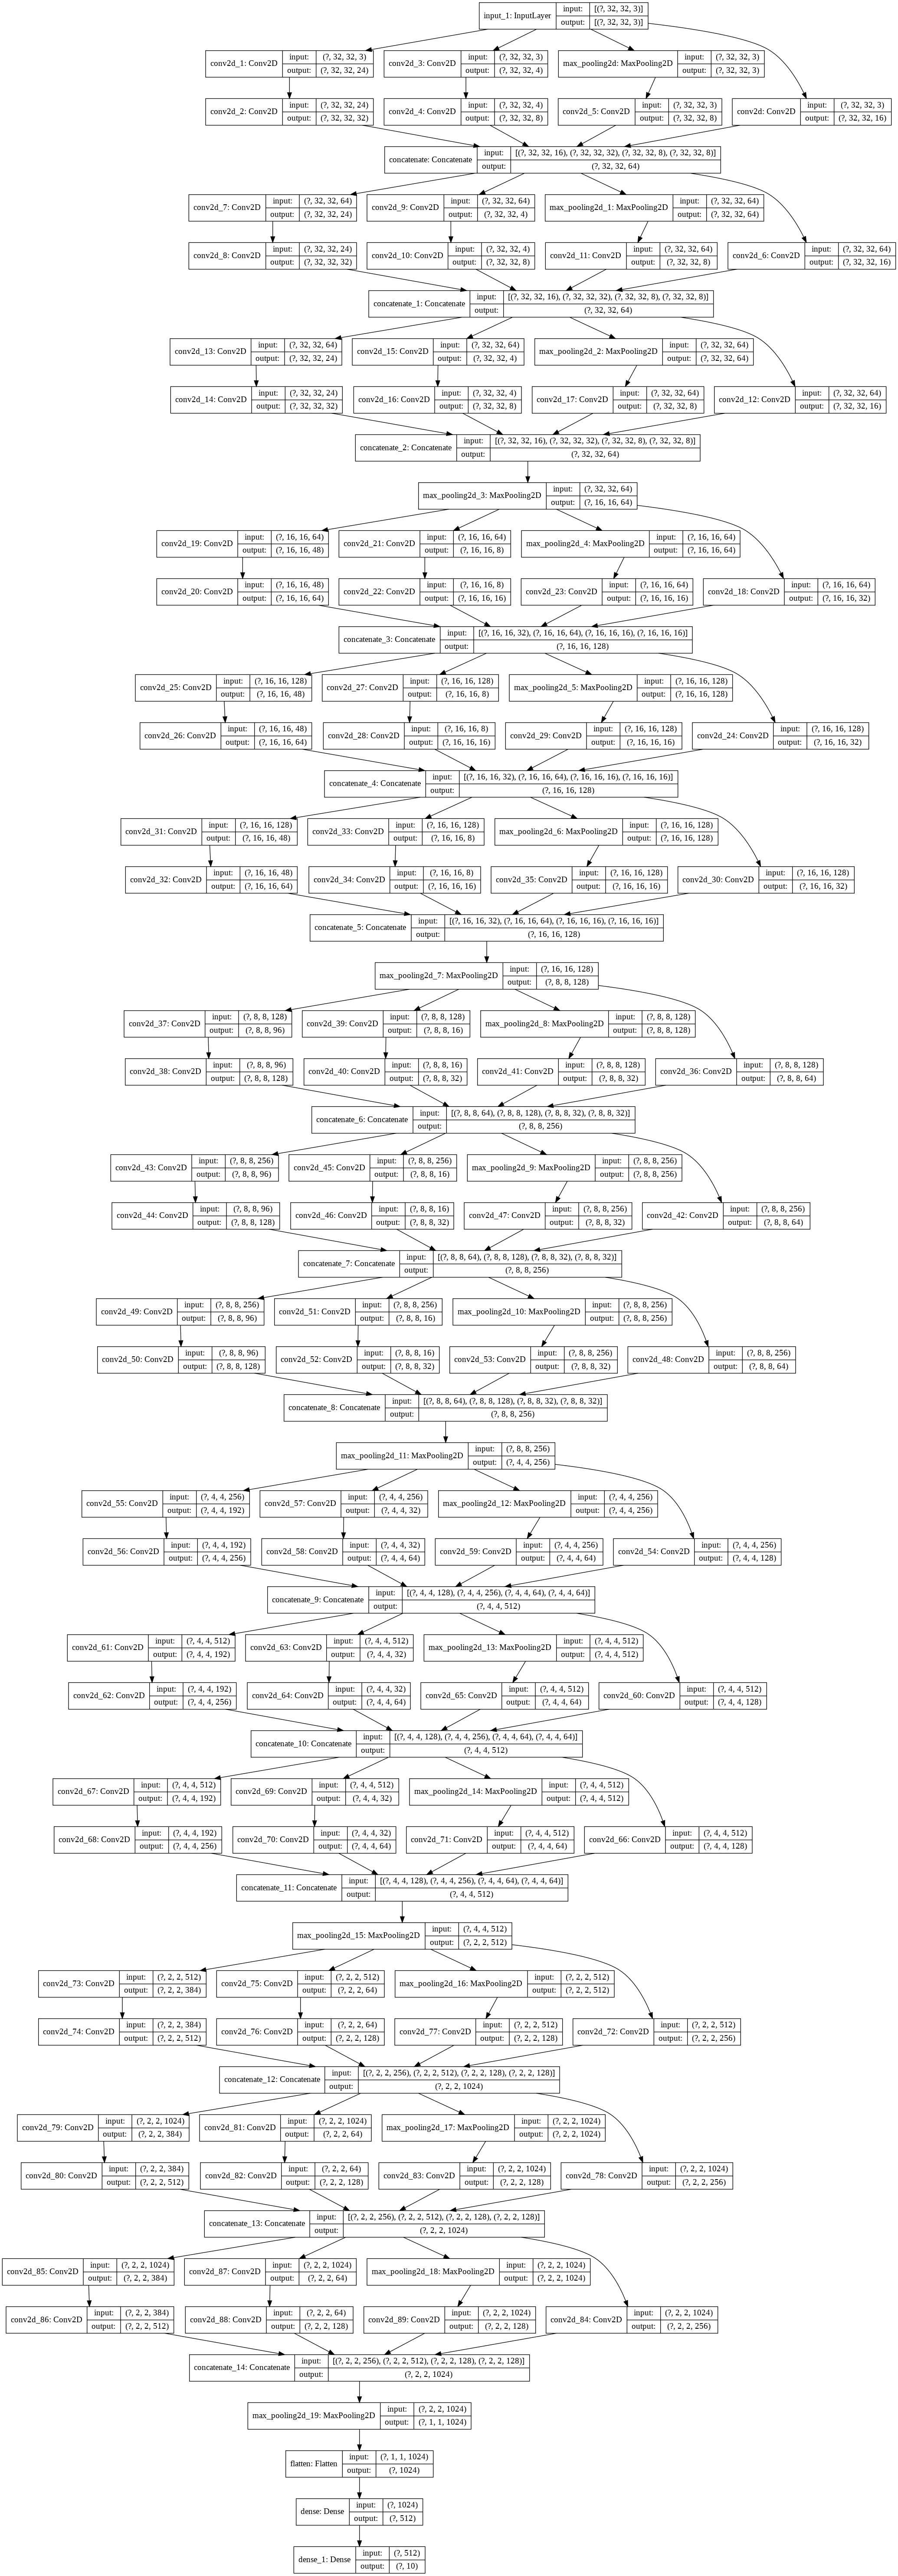

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.layers import Flatten

# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
# define model input
visible = Input(shape=(32, 32, 3))

#layer = inception_module(visible, 8, 12, 16, 2, 4, 4)
#layer = inception_module(layer, 8, 12, 16, 2, 4, 4)
#layer = MaxPooling2D(pool_size=(2, 2))(layer)

layer = inception_module(visible, 16, 24, 32, 4, 8, 8)
layer = inception_module(layer, 16, 24, 32, 4, 8, 8)
layer = inception_module(layer, 16, 24, 32, 4, 8, 8)
layer = MaxPooling2D(pool_size=(2, 2))(layer)

layer = inception_module(layer, 32, 48, 64, 8, 16, 16)
layer = inception_module(layer, 32, 48, 64, 8, 16, 16)
layer = inception_module(layer, 32, 48, 64, 8, 16, 16)
layer = MaxPooling2D(pool_size=(2, 2))(layer)

layer = inception_module(layer, 64,96,128,16,32,32)
layer = inception_module(layer, 64,96,128,16,32,32)
layer = inception_module(layer, 64,96,128,16,32,32)
layer = MaxPooling2D(pool_size=(2, 2))(layer)

layer = inception_module(layer, 128,192,256,32,64,64)
layer = inception_module(layer, 128,192,256,32,64,64)
layer = inception_module(layer, 128,192,256,32,64,64)
layer = MaxPooling2D(pool_size=(2, 2))(layer)

layer = inception_module(layer, 256,384,512,64,128,128)
layer = inception_module(layer, 256,384,512,64,128,128)
layer = inception_module(layer, 256,384,512,64,128,128)
layer = MaxPooling2D(pool_size=(2, 2))(layer)




layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
layer = Dense(num_classes, activation='softmax')(layer)

# create model
model = Model(inputs=visible, outputs=layer)
# compile model
epochs = 50
##lrate = 0.01
#decay = lrate/epochs
#nadam=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

# summarize model
model.summary()

plot_model(model, show_shapes=True, to_file='inception_module.png')

In [ ]:
model3=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=64)

Epoch 1/50
782/782 [==============================] - 129s 165ms/step - loss: 2.3029 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/50
782/782 [==============================] - 127s 162ms/step - loss: 2.3027 - accuracy: 0.0981 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/50
782/782 [==============================] - 127s 162ms/step - loss: 2.3027 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/50
782/782 [==============================] - 127s 162ms/step - loss: 2.3027 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/50
782/782 [==============================] - 127s 162ms/step - loss: 2.3027 - accuracy: 0.0994 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/50
782/782 [==============================] - 127s 162ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/50
782/782 [==============================] - 127s 162ms/step - loss: 2.3027 - accuracy: 0.0965 - val_loss: 2.3026 -

KeyboardInterrupt: ignored

# Custom Resnet - 89% validation accuracy

In [ ]:
from keras.layers import add
from keras.layers import Activation
from keras.layers import BatchNormalization 
from keras.layers import MaxPooling2D 
from keras.layers import Dropout 

def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
  
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
	# activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 32, 32, 64)   36928       conv2d_91[0][0]                  
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 32, 32, 64)   256         input_2[0][0]                    
_______________________________________________________________________________________

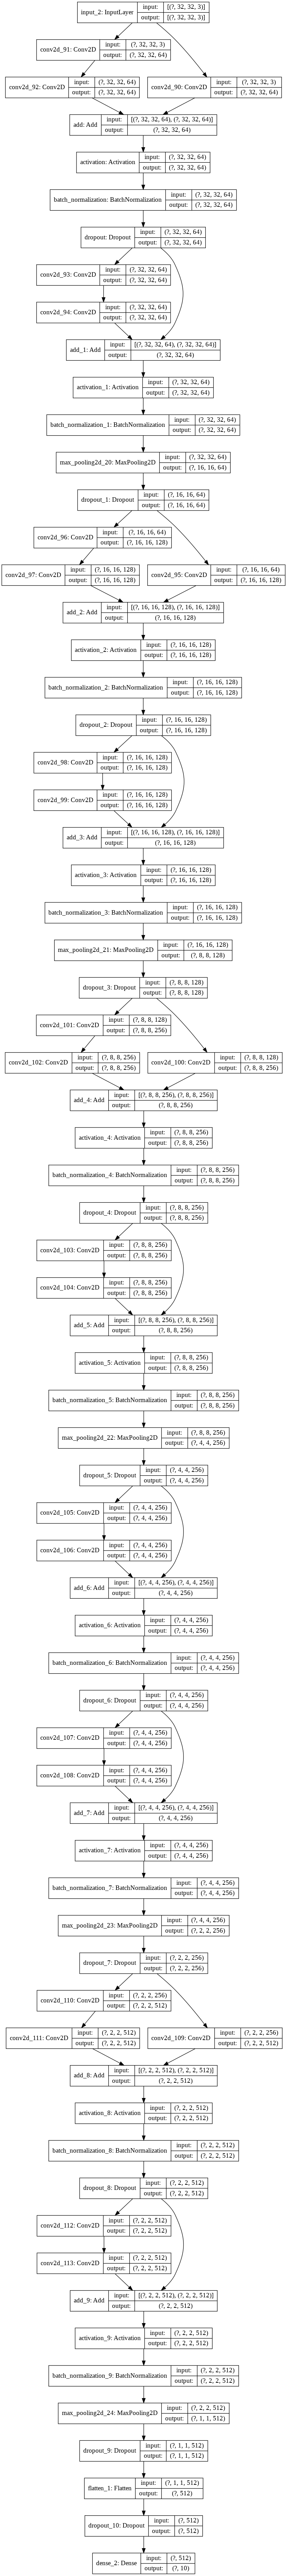

In [ ]:
visible = Input(shape=(32, 32, 3))
#layer = data_augmentation(visible)
layer = residual_module(visible, 64)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = residual_module(layer, 64)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.3)(layer)
layer = residual_module(layer, 128)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = residual_module(layer, 128)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.3)(layer)
layer = residual_module(layer, 256)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = residual_module(layer, 256)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.3)(layer)
layer = residual_module(layer, 256)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = residual_module(layer, 256)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.3)(layer)
layer = residual_module(layer, 512)
layer = BatchNormalization()(layer)
layer = Dropout(0.2)(layer)
layer = residual_module(layer, 512)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.2)(layer)
layer = Flatten()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(num_classes, activation='softmax')(layer)
model = Model(inputs=visible, outputs=layer)
# compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
# summarize model
model.summary()
plot_model(model, show_shapes=True, to_file='resnet module.png')

In [ ]:
model5=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=130, batch_size=64)

Epoch 1/130
782/782 [==============================] - 45s 57ms/step - loss: 2.2962 - accuracy: 0.2857 - val_loss: 21.2126 - val_accuracy: 0.1474
Epoch 2/130
782/782 [==============================] - 44s 56ms/step - loss: 2.1339 - accuracy: 0.2980 - val_loss: 2.0176 - val_accuracy: 0.2713
Epoch 3/130
782/782 [==============================] - 44s 56ms/step - loss: 2.0168 - accuracy: 0.3177 - val_loss: 76.1277 - val_accuracy: 0.1060
Epoch 4/130
782/782 [==============================] - 44s 56ms/step - loss: 2.0315 - accuracy: 0.2958 - val_loss: 1.8595 - val_accuracy: 0.3089
Epoch 5/130
782/782 [==============================] - 44s 56ms/step - loss: 1.7998 - accuracy: 0.3593 - val_loss: 1.9674 - val_accuracy: 0.3005
Epoch 6/130
782/782 [==============================] - 44s 56ms/step - loss: 2.0172 - accuracy: 0.3005 - val_loss: 3.2497 - val_accuracy: 0.2579
Epoch 7/130
782/782 [==============================] - 44s 56ms/step - loss: 1.7561 - accuracy: 0.3764 - val_loss: 1.7242 - val_

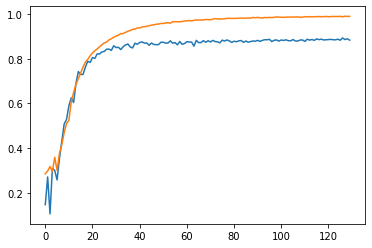

In [ ]:
plt.plot(model5.history['val_accuracy'])
plt.plot(model5.history['accuracy'])
print("Validation_accuracy: ",max(model5.history['val_accuracy']))

In [ ]:
print("Validation_accuracy: ",max(model5.history['val_accuracy']))

Validation_accuracy:  0.8924999833106995


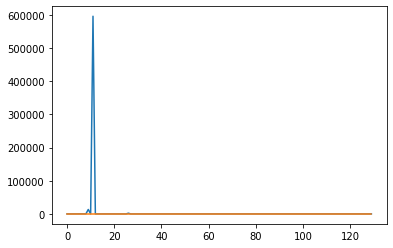

In [ ]:
plt.plot(model5.history['val_loss'])
plt.plot(model5.history['loss'])